# XGBoost Challenge
<hr>

## Predicting Future Outcomes from the Past ~10M Court Cases (1988-Present)

<br>

Using Legalist's technical assessment as our jumpoff, this notebook is intended to take you from start to finish with respect to working to solve a business problem using XGBoost, and leave you with a firm sense of how you might go about improving the pre-processing and modeling workflows to generate improved practical results.

So who the heck is Legalist?! Basically, Legalist is a Bay Area Y Combinator-backed company with ~$1B AUM seeking to use ML to connect investment capital with court litigants hoping to receive a payout at the end. Kinda wild. 🤯

<br>

<table width = "70%">
    <tr>
        <td>
            <img src="images/legalist-logo.png"/> 
        </td>
        <td>
            <img src="images/legalist-goals.png"/>
        </td>
    </tr>
</table>

<br>

We can glean straightaway how they define their business problem in their technical assessment overview:

In [1]:
from helpers import *
import warnings
warnings.filterwarnings('ignore')

show_problem_definition()

###### Let's get started!

**Note:** *You do not need to download and unzip the data, as it has already been placed in your working directory for you; the steps are included here for the purpose of showing you the entire workflow from start to finish.*

### [Data Download](https://www.fjc.gov/sites/default/files/idb/textfiles/cv88on_0.zip)

Uncomment and run the cell below to unzip the downloaded zip file after it's done downloading (optional).

In [2]:
# %%bash

# cd ~/Downloads/
# unzip cv88on_0.zip
# echo "Data download unzipped!"

Uncomment and run the cell below to move the unzipped data download into your working directory (optional).

In [3]:
# %%bash

# DEST="$PWD/raw data/cv88on.txt"
# mv ~/Downloads/cv88on.txt "$DEST"
# echo "Unzipped data download moved to 'raw data' folder in working directory!"

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from xgboost import XGBClassifier
from xgboost import plot_importance

import pickle

Having imported all of our dependencies, we can read the data into memory.

**Note:** *Given that the data is ~10M rows, this takes a minute or so; again, you can skip this step if your computer isn't up for the task, as the training data subset has already been saved to the `interim data` folder.*

In [5]:
all_cases = pd.read_csv('./raw data/cv88on.txt',
                        delimiter = "\t",
                        encoding="latin1",
                        low_memory=False)

A helper function has been created so that `show_data_dictionary` can be called at any point to provide more insight about the dataset features.

In [6]:
show_data_dictionary()

Some cursory assumptions have also been documented:

In [7]:
show_assumptions()

,column,assumption
0,NOS,"code 422 is most relevant, as it corresponds t..."
1,JURY,could be a useful feature
2,DEMANDED,could have predictive power
3,FILEJUDG,could be useful as a feature
4,FILEMAG,could be useful as a feature
5,TERMJUDG,could be useful as a feature
6,TERMMAG,could be useful as a feature
7,COUNTY,could have predictive power
8,TRANSOFF,could have predictive power
9,PROCPROG,this is important and i need to know how


According to Legalist, bankruptcy proceedings are a potentially profitable niche for investors [(source)](https://www.legalist.com/strategies/bankruptcy#:~:text=Since%202020%2C%20Legalist's%20bankruptcy%20funds,help%20fund%20the%20bankruptcy%20process); this data subset is sliced and saved in the `interim data` folder for model training, as mentioned.

In [8]:
bankruptcies = all_cases[all_cases.NOS == 422] # 422 corresponds to 'BANKRUPTCY APPEALS RULE 28 USC 158'
                                               # according to the data dictionary

# Saving parsed bankruptcy appellate cases in `interim data` folder    
bankruptcies.to_csv('./interim data/bankruptcies.csv')

![](./images/nos.png)

### Feature Selection and Data Pre-Processing

In [9]:
# Grabbing 8 features and two targets

bankruptcies = bankruptcies[['CIRCUIT',
                             'DISTRICT',
                             'TRANSOFF',
                             'ORIGIN',
                             'JURIS',
                             'JURY',
                             'COUNTY',
                             'PROCPROG',
                             'DISP',
                             'JUDGMENT'
                           ]]

# Must encode columns with mixed data types; everything winds up being cast as type 'int'
encoder = LabelEncoder()
bankruptcies['DISTRICT'] = encoder.fit_transform(bankruptcies['DISTRICT'])
bankruptcies['JURY'] = encoder.fit_transform(bankruptcies['JURY'])
bankruptcies['TRANSOFF'] = bankruptcies['TRANSOFF'].astype('int')

bankruptcies.to_csv('./processed data/encoded_bankruptcies.csv')

In [10]:
bankruptcies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101741 entries, 197 to 9676273
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   CIRCUIT   101741 non-null  int64
 1   DISTRICT  101741 non-null  int64
 2   TRANSOFF  101741 non-null  int64
 3   ORIGIN    101741 non-null  int64
 4   JURIS     101741 non-null  int64
 5   JURY      101741 non-null  int64
 6   COUNTY    101741 non-null  int64
 7   PROCPROG  101741 non-null  int64
 8   DISP      101741 non-null  int64
 9   JUDGMENT  101741 non-null  int64
dtypes: int64(10)
memory usage: 8.5 MB


### Data Modeling

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy: 80.47%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

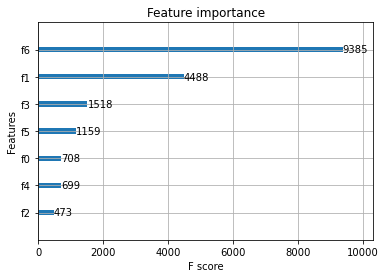

In [11]:
bankruptcies = pd.read_csv('./processed data/encoded_bankruptcies.csv', index_col=0)

df = bankruptcies.values

X = df[:,0:7]
y = df[:,9] # You can change the 9 to an 8 here if you want to use DISP as the target

# Encoding target column
encoder = LabelEncoder()
label_encoded_y = encoder.fit_transform(y)

# Setting random seed and a test data subset size of 30%
seed = 42
test_size = 0.30

# Perform train/test split; note that best practices
# would dictate that a validation set also be created,
# but we're skipping it for the sake of simplicity

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    label_encoded_y,
                                                                    test_size = test_size,
                                                                    random_state = seed)

# Using all available CPUs by passing -1 here 
model = XGBClassifier(nthread = -1)

# Fitting model to trainign data
model.fit(X_train, y_train)

# Showing model parameters; useful info when it comes
# to hypertuning, which you'll learn more about soon
print(model)

# Logging model predictions
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Gauging model accuracy
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy: %.2f%%" % (accuracy * 100.0))

# Plotting feature importance
plot_importance(model)

# Uncomment the line below to save file to 'models' folder
# pickle.dump(model, open("./models/xgb_bankruptcy_judgment_predictor.pickle", "wb"))

### Model Evaluation

In [12]:
# Show confusion matrix, which provides a matrix
# containing our models (mis)classifications
confusion_matrix(y_test, y_pred)

array([[18638,  1107,     4,    28,     0,     0],
       [  256,  5868,     1,    27,     0,     0],
       [  695,   128,     4,    10,     0,     0],
       [ 2507,   568,     4,    50,     0,     0],
       [  361,    16,     0,     0,     0,     0],
       [   61,   185,     0,     4,     0,     1]])

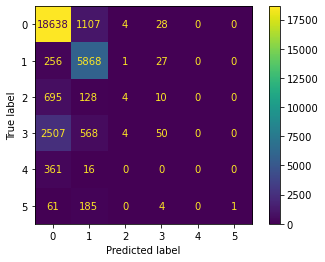

In [13]:
# Plotting a viz of the above matrix
plot_confusion_matrix(model, X_test, y_test)

What?! Those aren't the classes contained in the original dataset! Let's talk about that...

### Discussion and Conclusion

In [14]:
# Judgment classes contained in original dataset
bankruptcies['JUDGMENT'].unique()

array([-8,  1,  4,  2,  3,  0])

We can see that our tranformed `y_test` column contains a some ones and zeros...

In [15]:
y_test

array([1, 0, 0, ..., 0, 0, 0])

...but they don't correspond to classes `1` and `0` -- `1` actually means `0` and `0` actually means `-8`, as revealed via the `inverse_transform` method.

In [16]:
encoder.inverse_transform(np.array(y_test))

array([ 0, -8, -8, ..., -8, -8, -8])

That means our model predictions would need to be deciphered using said method, as illustrated below:

In [17]:
# Making predictions is kinda clunky in the sense that
# your observation must be wrapped in square brackets
# and passed to `np.array` for proper vectorization;
# note the predicted JUDGMENT of 1

model.predict(np.array([X_test[0]]))

array([1])

Inverse transformation reveals that the predicted JUDGMENT class is actually `0`.

In [18]:
observation = [X_test[0]]
vector = np.array(observation)
prediction = model.predict(vector)

encoder.inverse_transform(prediction)

array([0])

Looking back at our confusion matrix, it seems as though most cases are being predicted to fall into either classes `0` or `-8` (keeping in mind the inverse-transformed translation of these classes).

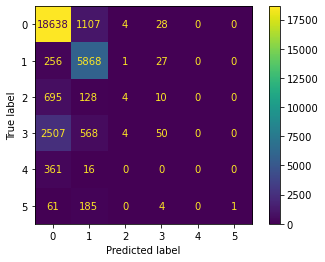

In [19]:
plot_confusion_matrix(model, X_test, y_test)

Our model basically learned nothing:
![](./images/judgment.png)
<br>
##### But why though?!

In [20]:
# Count of each JUDGMENT class in bankruptcy data subset
bankruptcies.groupby('JUDGMENT')['DISP'].count()

JUDGMENT
-8    65881
 0    20651
 1     2751
 2    10278
 3     1346
 4      834
Name: DISP, dtype: int64

In [21]:
encoder.inverse_transform(model.predict(X_test)).tolist()

[0,
 -8,
 -8,
 -8,
 0,
 0,
 -8,
 -8,
 0,
 -8,
 0,
 -8,
 0,
 -8,
 -8,
 0,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 0,
 -8,
 0,
 -8,
 0,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 0,
 0,
 -8,
 0,
 0,
 -8,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 0,
 -8,
 0,
 0,
 -8,
 0,
 -8,
 -8,
 0,
 -8,
 0,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 0,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 0,
 0,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 0,
 0,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 0,
 0,
 -8,
 -8,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 -8,
 -8,
 2,
 -8,
 -8,
 -8,
 0,
 -8,
 0,
 -8,
 -8,
 -8,
 0,
 -8,
 0,
 0,
 -8,
 0,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 0,
 -8,
 -8,
 -8,
 -8,
 -8,
 -8,
 0,
 -8,


Oh...it looks like the majority of our bankruptcy appellate cases have been entered with a missing JUDGMENT code, so our classes are imbalanced -- lesson learned!

### Bonus: Loading a Model for Inferencing

In [22]:
file = './models/xgb_bankruptcy_judgment_predictor.pickle'

with open(file, 'rb') as f:
    model = pickle.load(f)

In [23]:
model.predict(np.array([X_test[0]]))

array([1])

In [24]:
encoder.inverse_transform(model.predict(np.array([X_test[0]])))

array([0])

##### [Additional reading](https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/)

You'll notice that I've provided a start notebook to get you going with your own workflow -- how would you improve the pre-processing and modeling workflows to produce a better classifier or predictor?! Which features would you use? What would your target be? What type of model would you select? How would you gauge performance and select the "best" model? 🤔🤓